In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

C:\Users\alexz\AppData\Local\Temp\ipykernel_32248\3053793566.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load in data

In [ ]:
# Load in data (go back two parent directories)
data = pd.read_csv('../../data/investigation_train_large_checked.csv')
# Load in data descriptions
data_desc = pd.read_csv('../../data/data_description.csv', encoding='ISO-8859-1')

# Replace dutch for english names
name_mapping = dict(zip(data_desc['Feature (nl)'], data_desc['Feature (en)']))
# Rename the columns in the `data` DataFrame
data.rename(columns=name_mapping, inplace=True)

# Show data head
data.head()

,address_number_personal_records_database_addresses,address_number_different_districts,address_number_mail_address,address_number_residential_address_manual,address_days_at_address,address_latest_part_rotterdam,address_latest_neighborhood_groot_ijsselmonde,address_latest_neighborhood_new_westen,address_latest_neighborhood_other,address_latest_neighborhood_olde_north,...,type_hist_ind,type_hist_care_sector,type_ind,type_indication_secret_data,type_other,type_transport_logistics_horticulture,type_care_cleaning_wellbeing,Ja,Nee,checked
0,1,1,0,0,23240,1,0,0,0,0,...,1,0,0,0,0,0,0,0.617698,0.382302,False
1,4,2,1,1,1971,1,0,0,1,0,...,1,0,1,0,1,0,0,0.602167,0.397833,False
2,6,4,2,1,7247,0,0,0,1,0,...,1,0,1,0,0,0,0,0.512377,0.487623,False
3,3,2,0,1,8060,1,0,0,1,0,...,1,0,0,0,0,0,0,0.717796,0.282204,True
4,3,2,0,0,18705,1,0,0,0,0,...,1,0,1,0,0,0,0,0.705484,0.294516,True


## Check columns/features

In [4]:
# Check the features/columns
chunk_size = 10  # Number of column names per group
columns = data.columns.tolist()

# print in groups for better overview
for i in range(0, len(columns), chunk_size):
    print(columns[i:i + chunk_size])

['address_number_personal_records_database_addresses', 'address_number_different_districts', 'address_number_mail_address', 'address_number_residential_address_manual', 'address_days_at_address', 'address_latest_part_rotterdam', 'address_latest_neighborhood_groot_ijsselmonde', 'address_latest_neighborhood_new_westen', 'address_latest_neighborhood_other', 'address_latest_neighborhood_olde_north']
['address_latest_neighborhood_vreewijk', 'address_latest_place_other', 'address_latest_place_rotterdam', 'address_latest_district_charlois', 'address_latest_district_delfshaven', 'address_latest_district_feijenoord', 'address_latest_district_ijsselmonde', 'address_latest_district_kralingen_c', 'address_latest_district_north', 'address_latest_district_other']
['address_latest_district_prins_alexa', 'address_latest_district_city_center', 'address_unique_districts_ratio', 'appointment_registration_closed', 'appointment_number_words', 'appointment_past_year_appointment_plan', 'appointment_past_year

In [5]:
# check columns ja nee checked
print(data['Ja'])
print(data['Nee'])
print(data['checked'])

0         0.617698
1         0.602167
2         0.512377
3         0.717796
4         0.705484
            ...   
129995    0.627435
129996    0.623105
129997    0.630888
129998    0.478608
129999    0.526215
Name: Ja, Length: 130000, dtype: float64
0         0.382302
1         0.397833
2         0.487623
3         0.282204
4         0.294516
            ...   
129995    0.372565
129996    0.376895
129997    0.369112
129998    0.521392
129999    0.473785
Name: Nee, Length: 130000, dtype: float64
0         False
1         False
2         False
3          True
4          True
          ...  
129995    False
129996    False
129997    False
129998    False
129999    False
Name: checked, Length: 130000, dtype: bool


In [6]:
# sort on high to low importance
data_desc_sorted = data_desc.sort_values(by='Relative importance', ascending=False)
print(data_desc_sorted)


      ID                                   Feature (nl)  \
216  217                 persoon_leeftijd_bij_onderzoek   
290  291       relatie_overig_actueel_vorm__kostendeler   
140  141                    contacten_onderwerp_no_show   
90    91         competentie_vakdeskundigheid_toepassen   
142  143        contacten_onderwerp_overleg_met_inkomen   
..   ...                                            ...   
123  124        contacten_onderwerp_boolean_uitnodiging   
122  123            contacten_onderwerp_boolean_traject   
121  122    contacten_onderwerp_boolean_terugbelverzoek   
120  121  contacten_onderwerp_boolean_taaleis___voldoet   
314  315            typering_zorg__schoonmaak___welzijn   

                                          Feature (en) Datatype  \
216                        person_age_at_investigation      int   
290        relationship_other_current_form_cost_sharer      int   
140                           contacts_subject_no_show      int   
90                     

## Visualise relative importance (top 20)

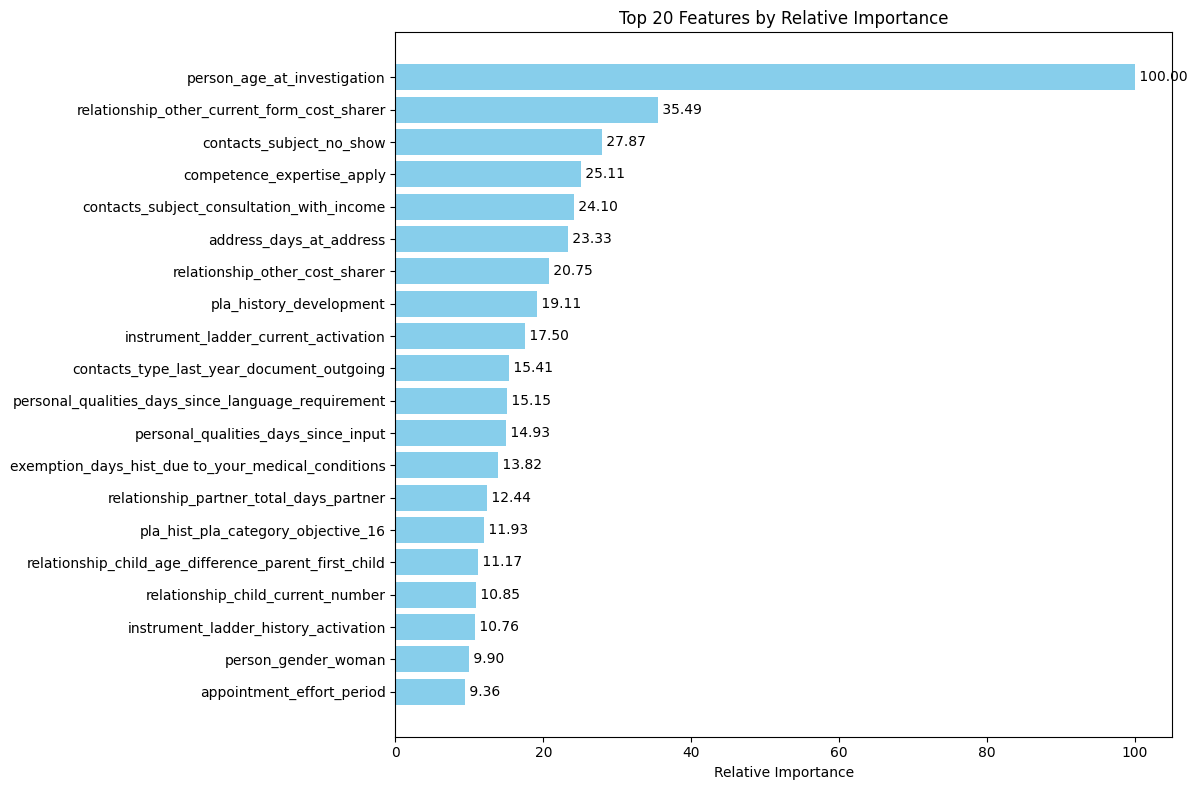

In [16]:
# visualise data description with imporant weight in histogram
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Select the top 10 features
top_20 = data_desc_sorted.head(20)
# For better visualization, reverse the DataFrame to have the highest importance at the top
top_20 = top_20[::-1]

# Set the figure size for better readability
plt.figure(figsize=(12, 8))

# Create a horizontal bar chart
plt.barh(top_20['Feature (en)'], top_20['Relative importance'], color='skyblue')

# Add labels and title
plt.xlabel('Relative Importance')
plt.title('Top 20 Features by Relative Importance')

# Display the values on the bars
for index, value in enumerate(top_20['Relative importance']):
    plt.text(value, index, f' {value:.2f}', va='center')

# Show the plot
plt.tight_layout()
plt.show()


## Visualise top 20 lowest importance

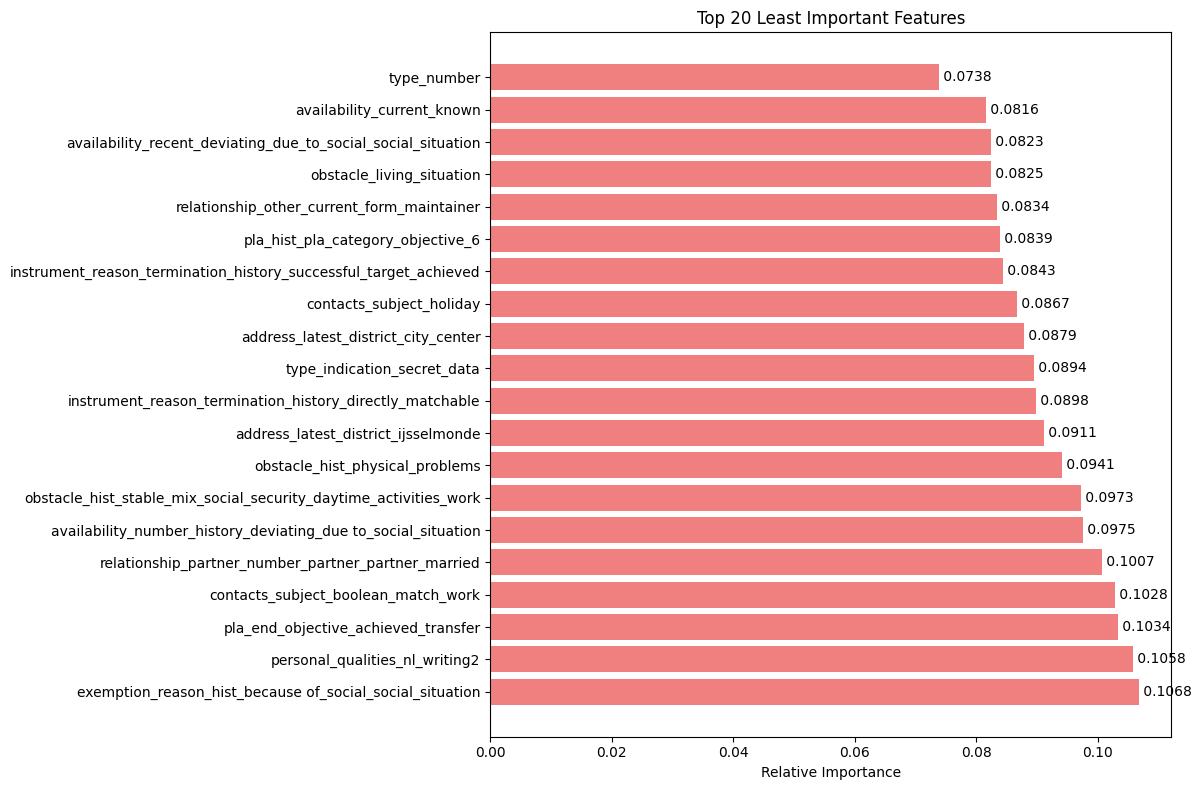

In [19]:
# Now the same but for top 10 lowest importance features

# Sort the data by 'Relative importance' in ascending order
data_desc_sorted_low = data_desc.sort_values(by='Relative importance', ascending=True)
# Remove 0 importance features
data_desc_sorted_low = data_desc_sorted_low.loc[data_desc_sorted_low['Relative importance'] != 0]
# Select the bottom 10 features
bottom_20 = data_desc_sorted_low.head(20)

# Create a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(bottom_20['Feature (en)'][::-1], bottom_20['Relative importance'][::-1], color='lightcoral')
plt.xlabel('Relative Importance')
plt.title('Top 20 Least Important Features')

# Add values on the bars
for index, value in enumerate(bottom_20['Relative importance'][::-1]):
    plt.text(value, index, f' {value:.4f}', va='center')

plt.tight_layout()
plt.show()
